In [1]:
#!pip install sentence-transformers
#!pip install matplotlib
#!pip install pandas
#!pip install plotly
#!pip install nbformat


In [2]:
import pandas as pd
from sentence_transformers import SentenceTransformer

# Load the CSV file
csv_file = "INBIOV2 direct parent.csv"
data = pd.read_csv(csv_file)

# Initialize the Sentence-Transformer model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Function to get the definition or fallback to comment
def get_definition(row):
    if pd.notna(row['classDefinition']) and row['classDefinition'].strip():
        return row['classDefinition']
    elif pd.notna(row['classComment']):
        return row['classComment']
    else:
        return None  # Return None if both are missing

# Apply the function to extract definitions
data['processedDefinition'] = data.apply(get_definition, axis=1)


c:\Users\talmu\Documents\GitHub\EcoHack-Ontology-Concept-Disambiguation\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Dictionary to store concept embeddings
embeddings = {}

# Generate embeddings
for _, row in data.iterrows():
    concept = row['classLabel']
    definition = row['processedDefinition']
    if definition:  # Only process rows with valid definitions
        embedding = model.encode(definition)
        embeddings[concept] = embedding


In [4]:
import pickle

output_file = "ontology_embeddings.pkl"
with open(output_file, "wb") as f:
    pickle.dump(embeddings, f)

print(f"Embeddings saved to {output_file}")


Embeddings saved to ontology_embeddings.pkl


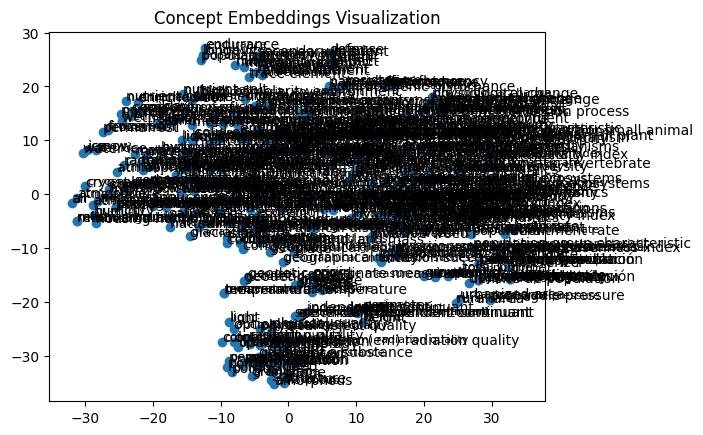

In [5]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Convert embeddings to a 2D array
embedding_matrix = np.array(list(embeddings.values()))
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embedding_matrix)

# Adjust label placement with small offsets
for i, concept in enumerate(embeddings.keys()):
    plt.annotate(concept, 
                 (reduced_embeddings[i, 0] + 0.3, reduced_embeddings[i, 1] + 0.3), 
                 fontsize=8)


# Plot the embeddings
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])
for i, concept in enumerate(embeddings.keys()):
    plt.annotate(concept, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))
plt.title("Concept Embeddings Visualization")
plt.show()


In [7]:
import plotly.express as px
import pandas as pd

# Prepare data for plotly
embedding_df = pd.DataFrame(reduced_embeddings, columns=["x", "y"])
embedding_df["concept"] = list(embeddings.keys())

# Create interactive plot
fig = px.scatter(embedding_df, x="x", y="y", text="concept", title="Concept Embeddings Visualization")
fig.update_traces(textposition="top center", marker=dict(size=8, color="blue"))
fig.show()